### 1 Login

#### 1.1 Load libraries for login

In [1]:
import csv
import degiroapi   # https://www.reddit.com/r/DEGIRO/comments/ze8xz7/unoffical_degiroapi_not_working_anymore/    # requires package request
from degiroapi.product import Product

#### 1.2 Read login information from "user_data.csv"
Syntax for the "user_data.csv" file:

<!-- language: lang-none -->
    username,password
    <my account name>,<my password>

In [2]:


# read the data from the CSV file
filename = "user_data.csv"

# open the CSV file in read mode
with open(filename, "r") as csvfile:
    # Create a CSV reader object
    csvreader = csv.reader(csvfile)

    # Read the first row to get the fields
    fields = next(csvreader)

    # Create a list to store the data
    user_data = []

    # Read the remaining rows and add the data to the list
    for row in csvreader:
        user_data.append(row)

#### <span style="color:red"> 1.3 Enter one time password (totp) </span>

In [3]:
totp="559462"

#### 1.4 Request login

In [4]:
# login to DeGiro & output all user data

degiro = degiroapi.DeGiro()
account_data=degiro.login(user_data[0][0], user_data[0][1],totp)
# pprint(account_data)

### 2 Scrutinize asset

#### 2.1 Load remaining Libraries

In [5]:

import matplotlib.pyplot as plt
from functions_module import current_date, convert_minutes_to_time, convert_minutes_to_time_from_reference_time, convert_time_to_minutes

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from pprint import pprint


#### 2.2 Search asset

In [6]:
# select specific product according to its isin and the listed product should possess the attribute "vwdIdentifierType" with the entry issueis
products = degiro.search_products('LU0252633754', 20) # get a maximum of 20 results

product=None
for i in range(len(products)):
    if "vwdIdentifierType" in products[i]:
        if products[i]["vwdIdentifierType"]=="issueid":
            product=products[i]
            break;
product=Product(product)

#### 2.3 Print asset infos

In [7]:
# specific product info

product_info=degiro.product_info(product.id)
pprint({key: str(value) for key, value in product_info.items()})

{'active': 'True',
 'buyOrderTypes': "['LIMIT', 'MARKET', 'STOPLOSS', 'STOPLIMIT', "
                  "'TRAILINGSTOP']",
 'category': 'H',
 'closePrice': '176.08',
 'closePriceDate': '2024-10-02',
 'contractSize': '1.0',
 'currency': 'EUR',
 'exchangeId': '194',
 'feedQuality': 'D15',
 'id': '886505',
 'isShortable': 'False',
 'isin': 'LU0252633754',
 'name': 'Amundi DAX III UCITS ETF Acc',
 'onlyEodPrices': 'False',
 'orderBookDepth': '0',
 'orderTimeTypes': "['DAY', 'GTC']",
 'productType': 'ETF',
 'productTypeId': '131',
 'qualitySwitchFree': 'False',
 'qualitySwitchable': 'False',
 'sellOrderTypes': "['LIMIT', 'MARKET', 'STOPLOSS', 'STOPLIMIT', "
                   "'TRAILINGSTOP']",
 'symbol': 'LYY7',
 'tradable': 'True',
 'vwdId': '480173840',
 'vwdIdentifierType': 'issueid',
 'vwdModuleId': '25'}


#### 2.4 Gather latest day price data from asset and save it in dataframe "df"

In [8]:
# define time Format conversion functions

# getting realtime and historical data from a stock
realprice = degiro.real_time_price(product.id, degiroapi.Interval.Type.One_Day)
data=realprice[1]['data']
df=pd.DataFrame(data,columns=['time','course'])
df['clock_time']=[convert_minutes_to_time_from_reference_time(int(df.time[i]), reference_time="00:00") for i in range(df['time'].shape[0])]
df=df[['clock_time','time','course']]


### 3 Export into csv file

Example of exported file:

<!-- language: lang-none -->
    clock_time,time,course
    9:04:00,544,175.36
    9:52:00,592,174.36
    10:10:00,610,174.48
    10:16:00,616,174.64
    11:14:00,674,174.96
    13:12:00,792,175.32
    13:27:00,807,175.42
    16:41:00,1001,174.34
    17:36:00,1056,174.66



In [9]:
# export the DataFrame "df" to a CSV file with a filename that carries the actual date
df[["clock_time","time", "course"]].to_csv(f'data/{current_date()}_{product.name}.csv', index=False)

### 4 Visualize

In [10]:
# time points of the day  in minutes from last midnight starting from 9 a.m. to 5:30 p.m. in 10 minutes steps
times_of_interest=range(convert_time_to_minutes("09:00"),convert_time_to_minutes("17:30")+5,10)

splines=[interp1d(df.iloc[:,1+i:2+i]['time'].dropna().values,df.iloc[:,2+i:3+i]['course'].dropna().values, kind='linear', fill_value='extrapolate') for i in range(0,int(df.shape[1]),3)]
df_equal_dt=pd.DataFrame([splines[j](np.array([i for i in times_of_interest])) for j in range(len(splines))],columns=[convert_minutes_to_time(i) for i in times_of_interest])
df_equal_dt.head(3)


,09:00,09:10,09:20,09:30,09:40,09:50,10:00,10:10,10:20,10:30,...,16:00,16:10,16:20,16:30,16:40,16:50,17:00,17:10,17:20,17:30
0,175.443333,175.235,175.026667,174.818333,174.61,174.401667,174.413333,174.48,174.662069,174.717241,...,174.568247,174.512577,174.456907,174.401237,174.345567,174.392364,174.450545,174.508727,174.566909,174.625091


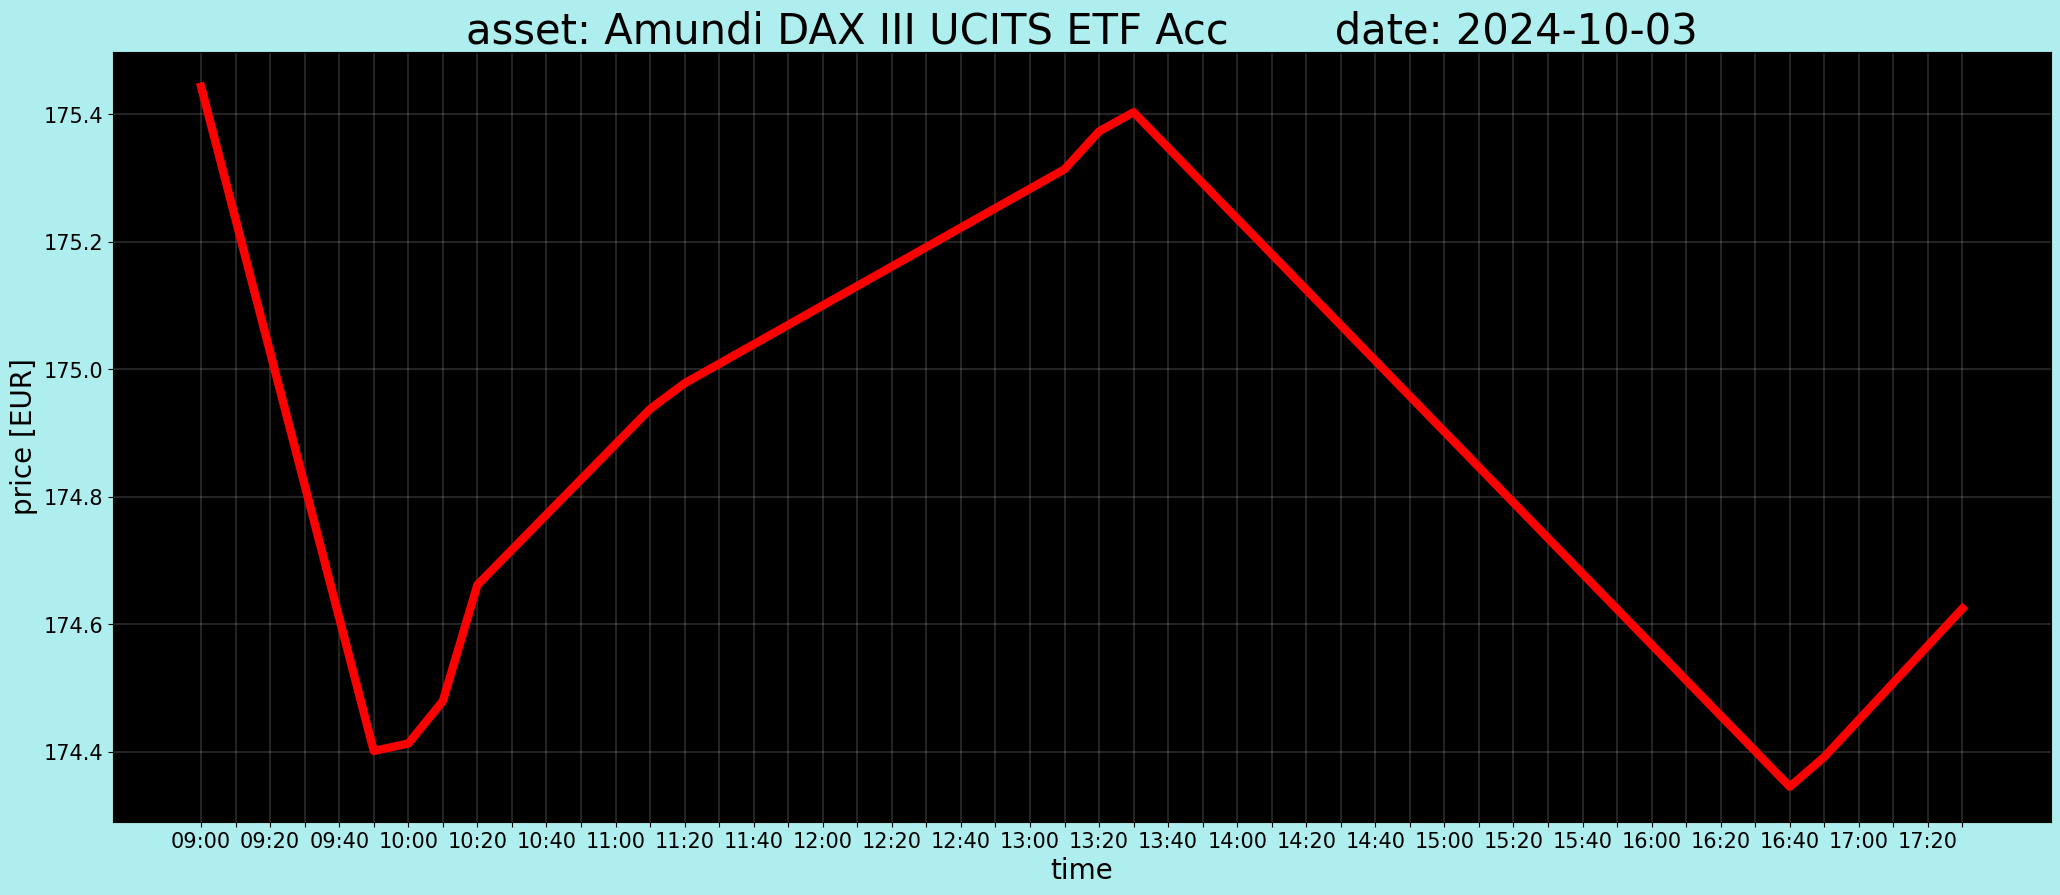

In [11]:
fig = plt.figure(figsize=(25, 10), facecolor='paleturquoise',edgecolor='red')
# plt.plot(df.clock_time, df.course, linestyle="solid", color='red', linewidth=6)
plt.plot(df_equal_dt.columns.values, df_equal_dt.values[0], linestyle="solid", color='red', linewidth=6)
for label in plt.gca().xaxis.get_ticklabels()[1::2]:
    label.set_visible(False)

plt.xlabel("time",fontsize=20)
plt.ylabel("price ["+product_info['currency']+"]",fontsize=20)
plt.grid(lw=0.3)
plt.title("asset: " + product.name+  "        date: " + current_date(),fontsize=30)
plt.gca().axes.set_facecolor('xkcd:black')
plt.tick_params(axis='x', which='major', labelsize=15)
plt.tick_params(axis='y', which='major', labelsize=15)
# fig.patch.set_facecolor('xkcd:light gray')
# plt.legend(fontsize=15)
plt.show()
